# Predictive Analysis



*Develop a model that predicts customer behaviour and apply it to the rest of*
*the customer base to the rest of the customer base.* 


In [11]:
import json
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg
import statsmodels.api as sm
from pathlib import Path
from datetime import datetime
from scipy import stats
from sklearn.preprocessing import LabelEncoder
from tabulate import tabulate

import psutil
import warnings
from sinfo import sinfo

warnings.filterwarnings("ignore")
plt.rcdefaults()

In [2]:
class WinsorizedMeanCalculator:
    def __init__(self, lower_percentile=0.05, upper_percentile=0.95):
        """
            Winsorized Mean (5%)
            ---
            Args:
                lower_percentile=0.05
                upper_percentile=0.95
            ---
            The k% winsorized mean is obtained by calculating the 
            arithmetic mean after replacing the k% of the smallest values 
            by the smallest value of the remaining values and the k% of the 
            largest values by the largest value of the remaining values.
        """
        self.lower_percentile = lower_percentile
        self.upper_percentile = upper_percentile

    def winsorize(self, data):
        lower_limit = np.percentile(data, self.lower_percentile * 100)
        upper_limit = np.percentile(data, self.upper_percentile * 100)

        # Replace extreme values with the adjacent limits
        data = np.where(data < lower_limit, lower_limit, data)
        data = np.where(data > upper_limit, upper_limit, data)

        return data

    def calcu_winsor_mean(self, column):
        winsorized_data = self.winsorize(column)
        return np.mean(winsorized_data)

winsor = WinsorizedMeanCalculator()

def range(col):
    return col.max() - col.min()

def ksfunc(col):
    return stats.kstest(col, stats.norm.cdf,
                        args=(col.mean(), col.std()))

def cdv(col):
    """
        Coefficient of Variation Centered on the Mean.
        ---
        (std / mean) * 100
        ---
        Reasonable dispersion is associated with coefficients of variation 
        less than 50. Coefficients of variation greater than 50 indicate a 
        lot of dispersion. Coefficients greater than 100 are generally 
        indicative of strong anomalies in the data.
    """
    return (col.std() / abs(col.mean())) * 100

def trimean(series):
    """
        BESA (best easy systematic average)
        ---
        (Q1 + 2*Q2 + Q3) / 4
        ---
        Highly robust central tendency statistic
    """
    Q1 = series.quantile(0.25)
    median = series.median()
    Q3 = series.quantile(0.75)
    return (Q1 + 2 * median + Q3) / 4


In [3]:
# Storing path
path = Path("../data/ifood_cleaned.csv")

# Read CSV with pandas
data = pd.read_csv(path)

# Read columns dtypes
with open('../data/cleaned_dtypes.json', 'r') as f:
    data_types = json.load(f)

data = data.astype(data_types)

In [4]:
data["MntTotal_cat"], intervals = pd.cut(data["MntSpentTotal"], 6, 
                                         precision=0, retbins=True)

temp, first_int = pd.cut(np.arange(2, 426), 5, retbins=True)
bins = list(first_int) + list(intervals[2:])

data["MntTotal_cat"], intervals = pd.cut(data["MntSpentTotal"], bins, 
                                         precision=0, right=False, 
                                         retbins=True, ordered=True)

data["Recency_cat"] = data["Recency_cat"].cat.as_ordered()
data["Age_cat"] = data["Age_cat"].cat.as_ordered()

data["Education"] = data["Education"].cat.reorder_categories(["Basic", 
                                                              "Graduation", 
                                                              "2n Cycle", 
                                                              "Master", 
                                                              "PhD"], 
                                                              ordered=True)

data["Income_cat"] = data["Income_cat"].cat\
    .reorder_categories(['D1', 'D2', 'D3', 'D4', 'D5', 
                         'D6', 'D7', 'D10'], ordered=True)

## Stepwise Regression

In [5]:
# Stepwise selection function

def stepwise_selection(X, y):
    selected_vars = []
    remaining_vars = list(X.columns)
    
    while remaining_vars:
        best_pvalue = float('inf')
        best_var = None
        
        for var in remaining_vars:
            model = sm.OLS(y, sm.add_constant(X[selected_vars + [var]])).fit()
            pvalue = model.pvalues[var]
            
            if pvalue < best_pvalue:
                best_pvalue = pvalue
                best_var = var
        
        if best_pvalue < 0.05:
            selected_vars.append(best_var)
            remaining_vars.remove(best_var)
        else:
            break
    
    return selected_vars



In [6]:
data["TotalCmp"] = data["AcceptedCmpTotal"] + data["Response"]
data["CustomerFor"] = data["CustomerFor"].dt.days

In [7]:

data["CustomerFor"] = data["CustomerFor"] * 1
data["CustomerFor"] = data["CustomerFor"].astype("Int64")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2205 entries, 0 to 2204
Data columns (total 41 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   ID                   2205 non-null   Int64         
 1   Year_Birth           2205 non-null   Int64         
 2   Year_Old             2205 non-null   Int64         
 3   CustomerFor          2205 non-null   Int64         
 4   Dt_Customer          2205 non-null   datetime64[ns]
 5   Education            2205 non-null   category      
 6   Marital_Status       2205 non-null   category      
 7   Income               2205 non-null   Int64         
 8   Kidhome              2205 non-null   Int64         
 9   Teenhome             2205 non-null   Int64         
 10  ChildrenHome         2205 non-null   Int64         
 11  Recency              2205 non-null   Int64         
 12  MntSpentTotal        2205 non-null   Int64         
 13  MntWines             2205 non-nul

In [8]:
le = LabelEncoder()

data["Age_cat_enc"] = le.fit_transform(data["Age_cat"])
data["Income_cat_enc"] = le.fit_transform(data["Income_cat"])
data["Education_enc"] = le.fit_transform(data["Education"])
data["Marital_Status_enc"] = le.fit_transform(data["Marital_Status"])

y = data["TotalCmp"]
x = data[["NumDealsPurchases", "NumCatalogPurchases", "NumStorePurchases", 
          "Z_CostContact", "Z_Revenue", "Age_cat_enc", "Income_cat_enc", "Recency",
          "Year_Old", "CustomerFor", "ChildrenHome", "Education_enc",
          "Marital_Status_enc", "MntWines", "MntFruits", "MntMeatProducts",
          "MntFishProducts", "MntGoldProds", "PurchaseLastMonth",
          ]]

In [9]:
y.info()

<class 'pandas.core.series.Series'>
RangeIndex: 2205 entries, 0 to 2204
Series name: TotalCmp
Non-Null Count  Dtype
--------------  -----
2205 non-null   Int64
dtypes: Int64(1)
memory usage: 19.5 KB


In [10]:
x = x.astype(float)

x = sm.add_constant(x)

y = y.astype(float)  

model = sm.OLS(y, x).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               TotalCmp   R-squared:                       0.315
Model:                            OLS   Adj. R-squared:                  0.310
Method:                 Least Squares   F-statistic:                     59.18
Date:                Wed, 24 Jul 2024   Prob (F-statistic):          1.52e-165
Time:                        17:16:17   Log-Likelihood:                -2458.8
No. Observations:                2205   AIC:                             4954.
Df Residuals:                    2187   BIC:                             5056.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
NumDealsPurchases      -0.0184    

In [11]:
selected_variables = stepwise_selection(x, y)
selected_variables


['MntWines',
 'NumStorePurchases',
 'Z_CostContact',
 'Z_Revenue',
 'ChildrenHome',
 'Recency',
 'Income_cat_enc',
 'Year_Old',
 'NumCatalogPurchases',
 'MntFishProducts',
 'Education_enc']

In [14]:
x = data[selected_variables]
x = x.astype(float)
x = sm.add_constant(x)

model = sm.OLS(y, x).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               TotalCmp   R-squared:                       0.312
Model:                            OLS   Adj. R-squared:                  0.309
Method:                 Least Squares   F-statistic:                     110.4
Date:                Wed, 24 Jul 2024   Prob (F-statistic):          7.15e-171
Time:                        17:17:37   Log-Likelihood:                -2464.3
No. Observations:                2205   AIC:                             4949.
Df Residuals:                    2195   BIC:                             5006.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
MntWines                0.0015   7

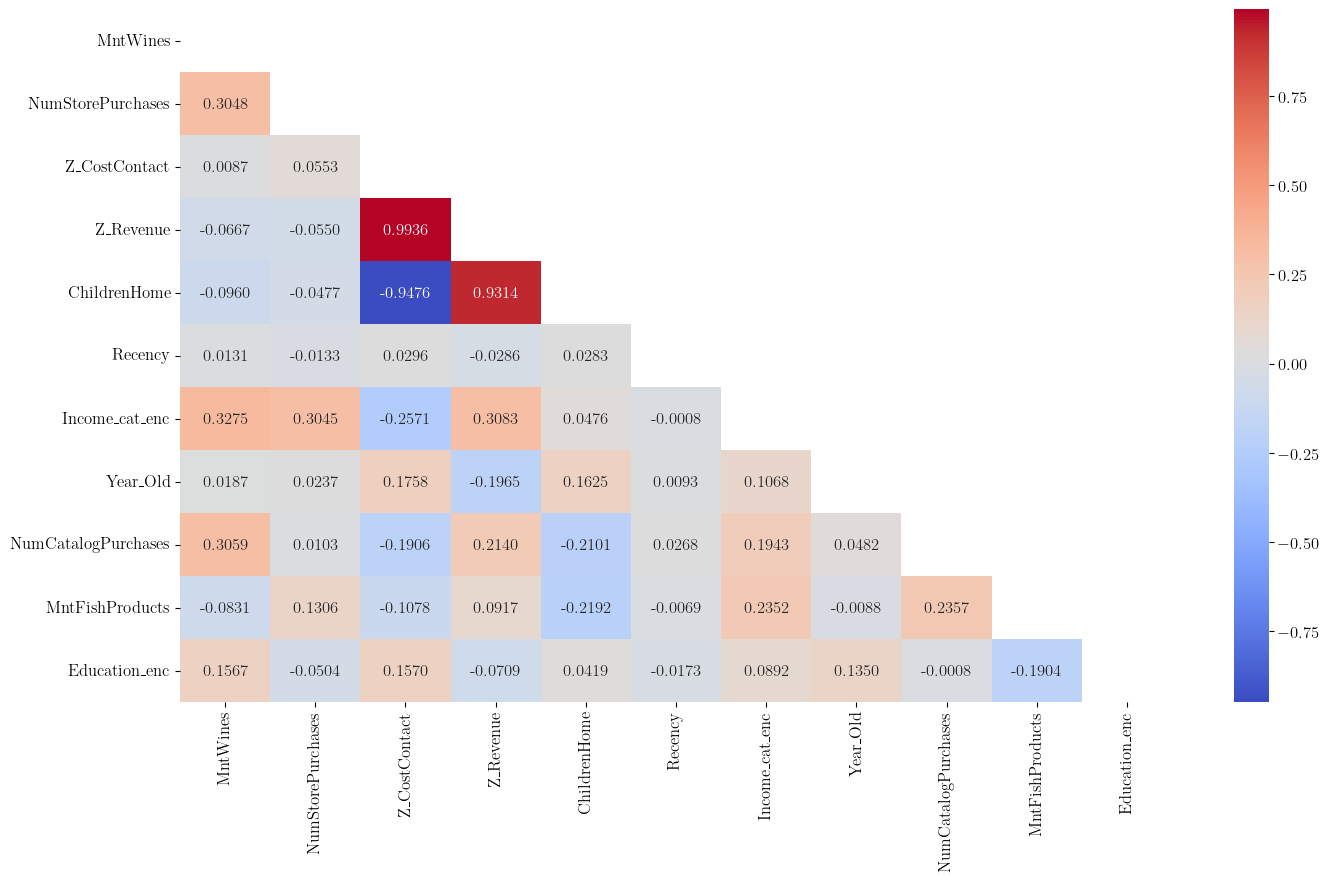

In [15]:
corr_matrix = data[selected_variables].pcorr()
mask = np.triu(np.ones_like(corr_matrix, dtype = bool))

with plt.style.context(["seaborn-v0_8-colorblind",
                   "./mplstyle/basic.mplstyle",
                   #"./mplstyle/scatter.mplstyle",
                   ]):
    
    sns.heatmap(corr_matrix, cmap="coolwarm", annot=True, mask=mask, fmt=".4f")
    plt.show()

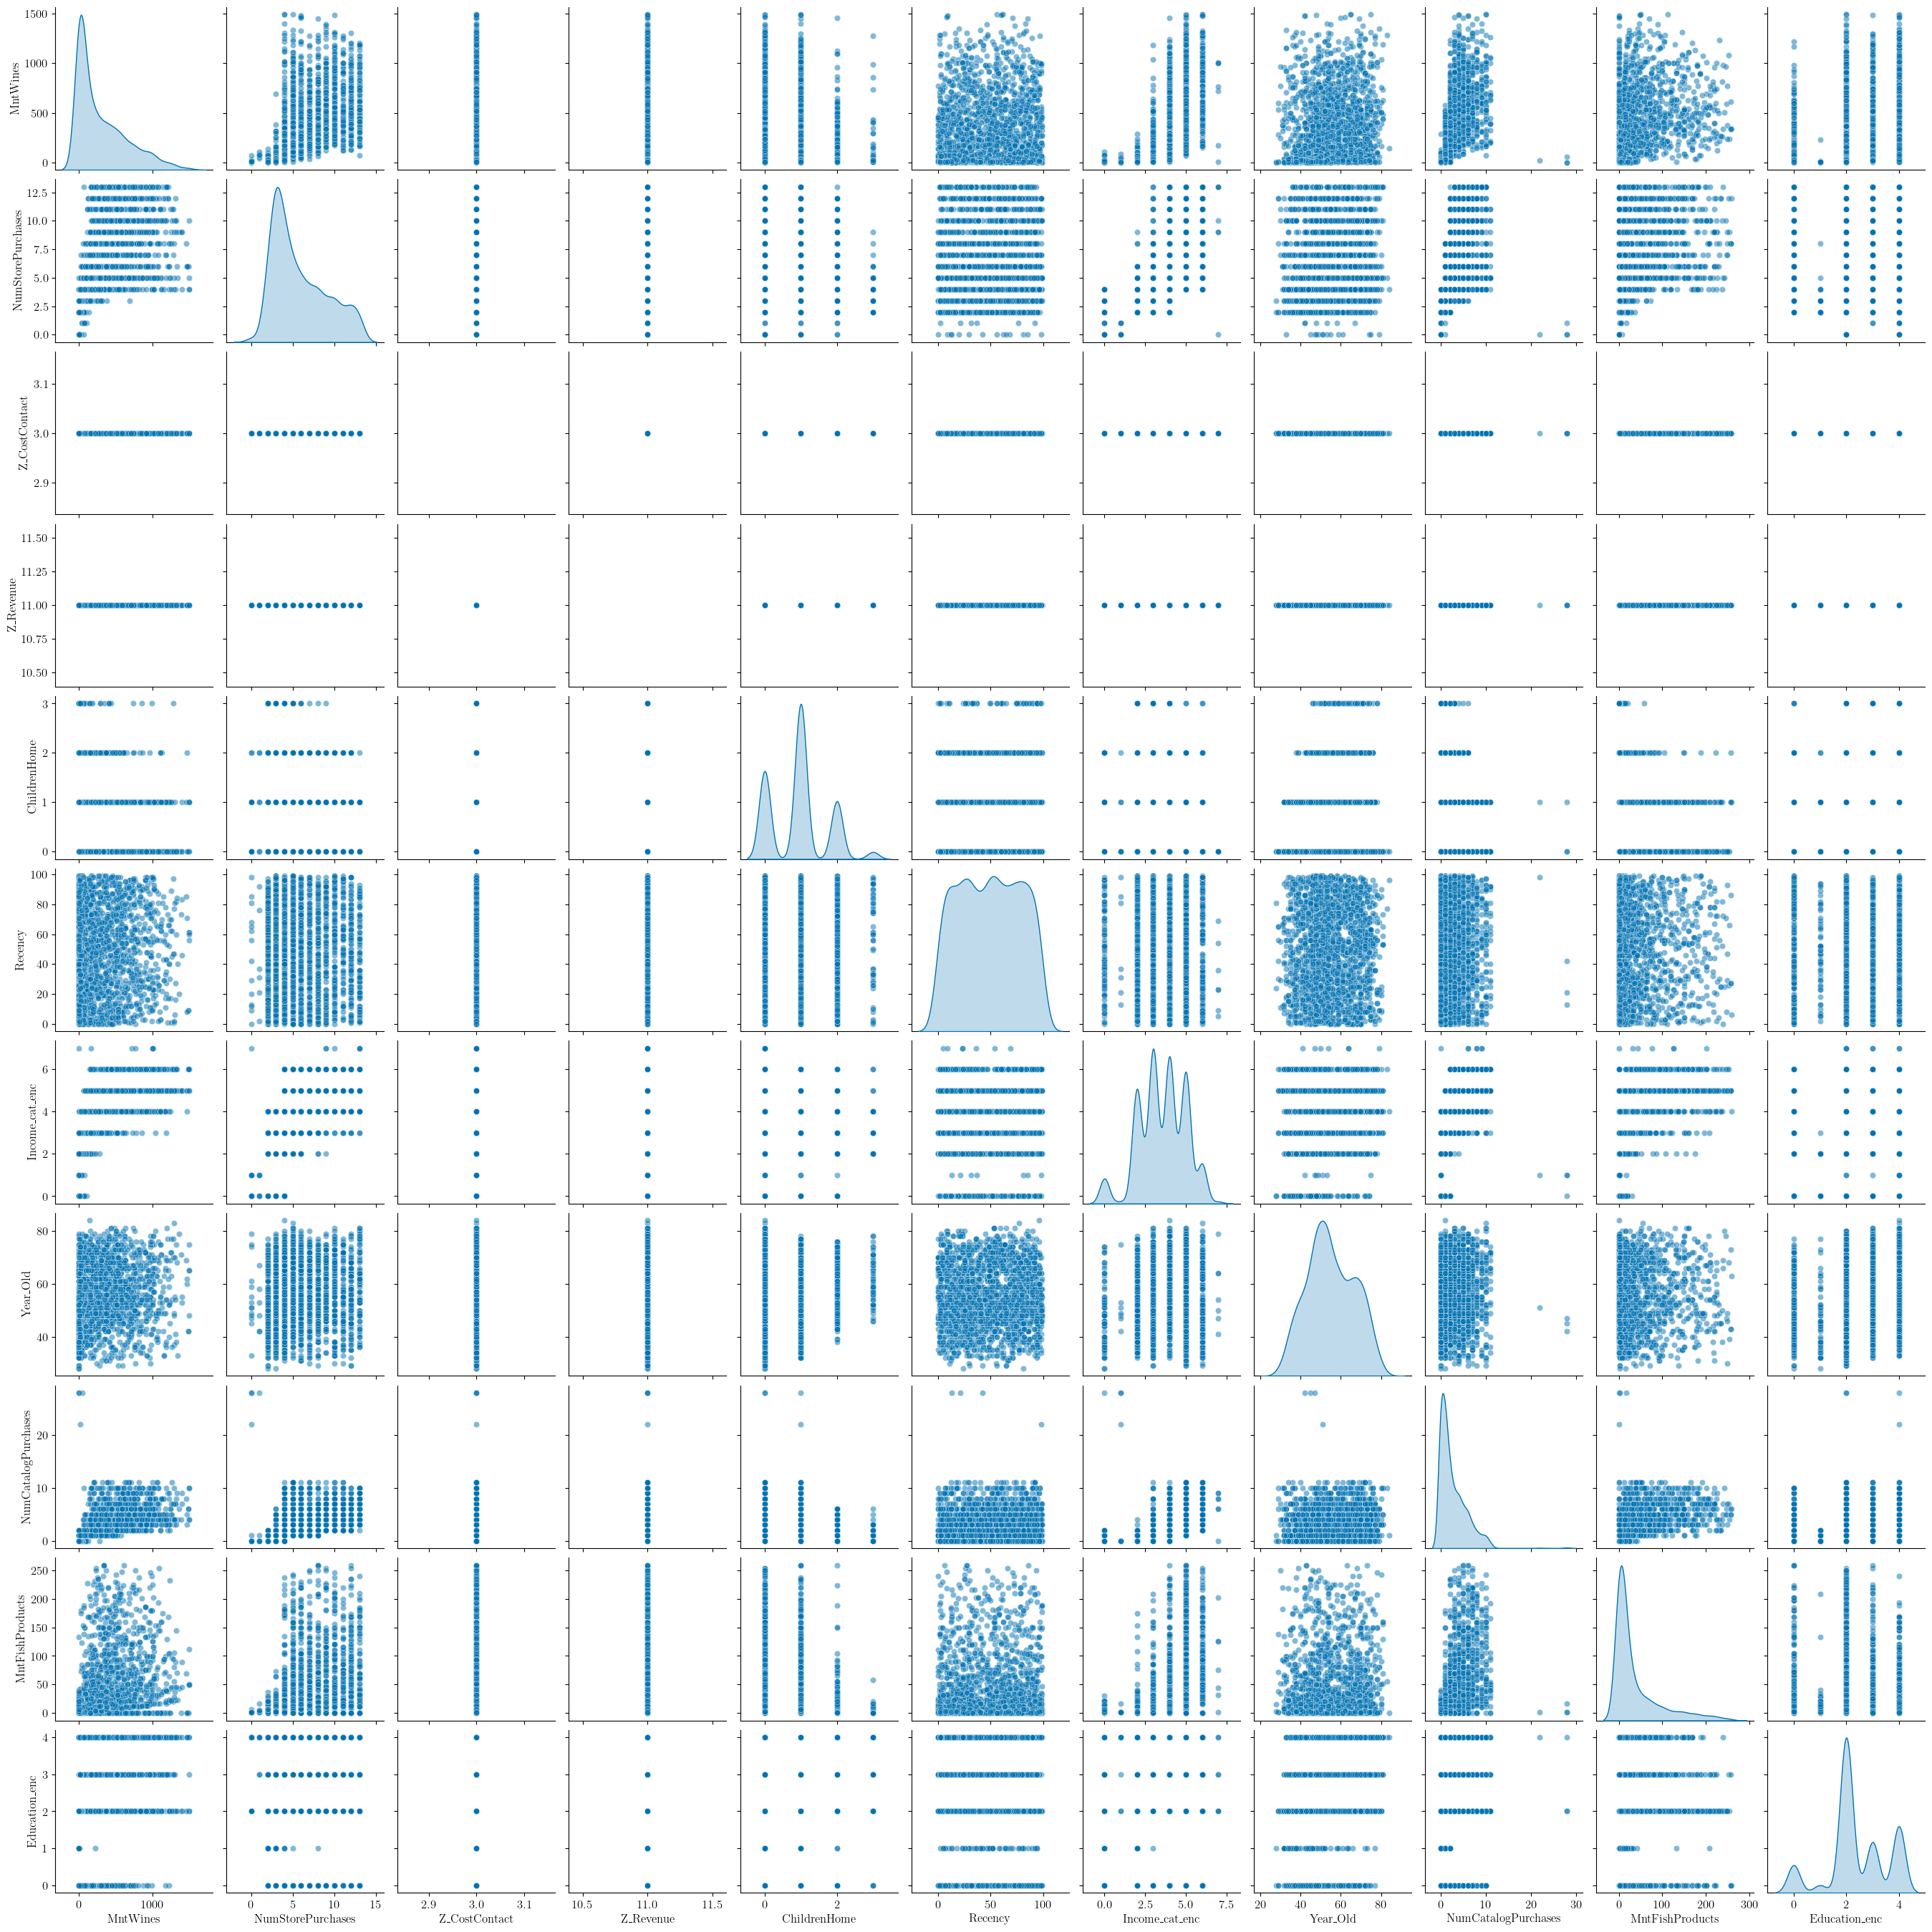

In [16]:
with plt.style.context(["seaborn-v0_8-colorblind",
                   "./mplstyle/basic.mplstyle",
                   #"./mplstyle/scatter.mplstyle",
                   ]):

    sns.pairplot(data[selected_variables], kind='scatter', diag_kind='kde', plot_kws={'alpha': 0.5})

    plt.show()

In [15]:
Y = data["TotalCmp"]
X = data["NumCatalogPurchases"]

X = X.astype(float)
Y = Y.astype(float)  

X = sm.add_constant(X)
model = sm.OLS(Y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               TotalCmp   R-squared:                       0.122
Model:                            OLS   Adj. R-squared:                  0.122
Method:                 Least Squares   F-statistic:                     307.3
Date:                Wed, 24 Jul 2024   Prob (F-statistic):           1.63e-64
Time:                        18:31:40   Log-Likelihood:                -2732.0
No. Observations:                2205   AIC:                             5468.
Df Residuals:                    2203   BIC:                             5479.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.1626    